In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import corner
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

# Intentando reproducir el artículo https://arxiv.org/abs/2104.01077

## Ejemplo basado en https://docs.pymc.io/pymc-examples/examples/samplers/SMC-ABC_Lotka-Volterra_example.html

In [2]:
data = np.random.normal(loc=0, scale=1, size=1000)

In [3]:
def normal_sim(a, b):
    return np.random.normal(a, b, 1000)

In [4]:
with pm.Model() as model:
    a = pm.Normal("a", mu=0, sd=5)
    b = pm.HalfNormal("b", sd=1)
#     s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="mean", epsilon=1, observed=data)
    s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="sort", epsilon=1, observed=data)

    trace, sim_data = pm.sample_smc(kernel="ABC", parallel=True, save_sim_data=True)
    idata = az.from_pymc3(trace, posterior_predictive=sim_data)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.002
Stage:   2 Beta: 0.008
Stage:   3 Beta: 0.029
Stage:   4 Beta: 0.097
Stage:   5 Beta: 0.304
Stage:   6 Beta: 0.808
Stage:   7 Beta: 1.000


In [5]:
# az.plot_trace(idata, kind="rank_vlines");

In [6]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,0.018,0.045,-0.067,0.099
b,1.013,0.039,0.941,1.086


<AxesSubplot:xlabel='s'>

/home/cosmocicatais/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


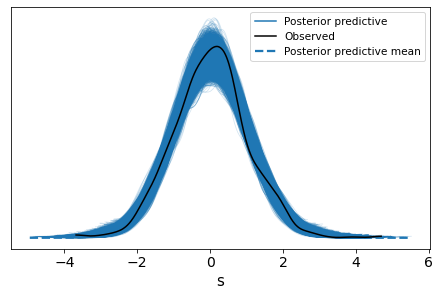

In [7]:
az.plot_ppc(idata,)

array([<AxesSubplot:title={'center':'a'}>,
       <AxesSubplot:title={'center':'b'}>], dtype=object)

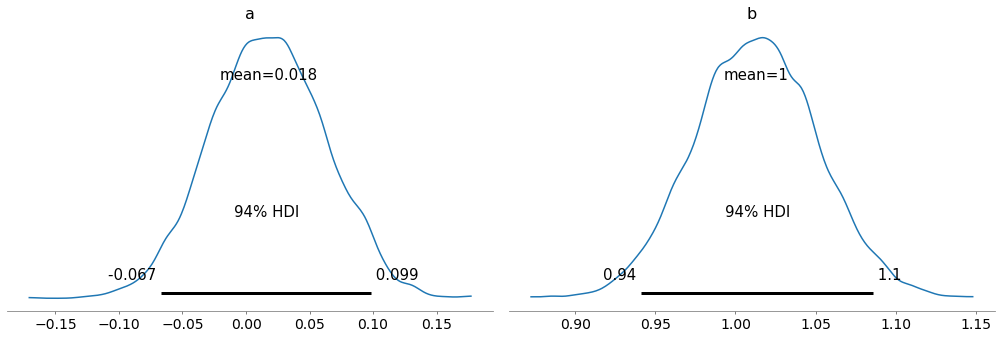

In [8]:
az.plot_posterior(idata)

<AxesSubplot:xlabel='a', ylabel='b'>

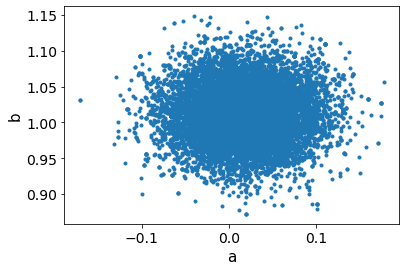

In [9]:
az.plot_pair(idata)

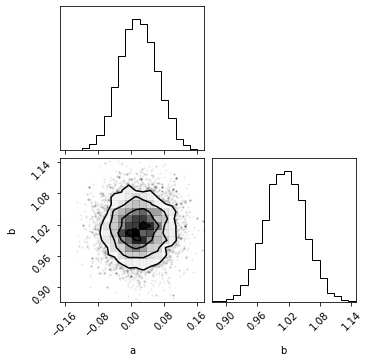

In [10]:
corner.corner(idata)
plt.show()

## Testing LCDM con H(z)

In [11]:
npoints= 1000

def Hlcdm(h0, om):
    z = np.linspace(0, 3, npoints).reshape(npoints, 1)
    return h0 * np.sqrt(om*(1+z)**3 + 1 - om)

In [12]:
h0lcdm = np.linspace(66, 70, npoints).reshape(npoints, 1)
omlcdm = np.linspace(0.29, 0.31, npoints).reshape(npoints,1)
zredshift = np.linspace(0, 3, npoints).reshape(npoints, 1)
hlcdm = Hlcdm(h0lcdm, omlcdm)
# hlcdm= Hlcdm(67, 0.3)
x = np.concatenate((zredshift, h0lcdm, omlcdm), axis=1)
np.shape(x)

(1000, 3)

In [13]:
def model(input_z):
    efirst = tf.keras.layers.Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = tf.keras.layers.Dense(200, activation='relu')(efirst)
    ehidden2 = tf.keras.layers.Dense(100, activation='relu')(ehidden)
    elast = tf.keras.layers.Dense(1, activation='linear')(ehidden2)
    return elast

input_z = tf.keras.layers.Input(shape = (3,))
neural_model = tf.keras.models.Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,801
Trainable params: 40,801
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_train = neural_model.fit(x, hlcdm, epochs=100, shuffle=True, validation_split=0.2)

Epoch 1/100
25/25 [==============================] - 1s 12ms/step - loss: 15602.6129 - val_loss: 13103.5498
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 3314.6258 - val_loss: 19555.2188
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 2649.7875 - val_loss: 19474.0664
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 2522.7891 - val_loss: 19503.7031
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 2584.5592 - val_loss: 17676.2734
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 2556.2697 - val_loss: 17637.5371
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 2547.9303 - val_loss: 17494.1133
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 2408.7460 - val_loss: 16729.4258
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 2488.9160 - val_loss: 18209.9707
Epoch 10/100
25/25 [========================

([], [])

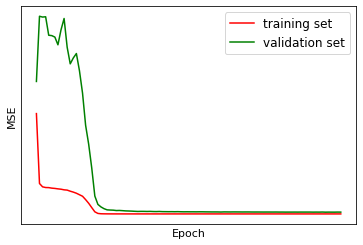

In [15]:
# plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])
# plt.savefig('loss_hz_DO.png')

In [16]:
news_h = neural_model.predict(x)

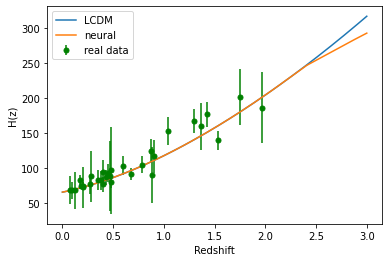

In [24]:
file = '../data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
z_data = data.values[:,0]
hz_data = data.values[:,1]
err_data = data.values[:,2]

plt.plot(zredshift, hlcdm, label='LCDM')
plt.xlabel('Redshift')
plt.plot(zredshift, news_h, label='neural')
plt.ylabel('H(z)')
plt.errorbar(z_data, hz_data, yerr=err_data, label='real data', fmt='g.', markersize=10)
plt.legend()

In [25]:
with pm.Model() as model2:
#     h0 = pm.Uniform('h0', lower=65, upper=75)
#     om = pm.Uniform("om", lower=0.25, upper=0.35)
    h0 = pm.Normal('h0', mu=70, sd=0.75)
    om = pm.Normal("om", mu=0.3, sd=0.05)
    s = pm.Simulator("s", Hlcdm, params=(h0, om), sum_stat="mean", epsilon=1, observed=news_h)

    trace, sim_data = pm.sample_smc(kernel="ABC", parallel=True, save_sim_data=True)
    idata = az.from_pymc3(trace, posterior_predictive=sim_data)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.038
Stage:   1 Beta: 0.311
Stage:   2 Beta: 1.000


In [26]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
h0,69.927,0.740,68.598,71.402
om,0.279,0.009,0.263,0.295


In [27]:
# az.plot_ppc(idata,)

array([<AxesSubplot:title={'center':'h0'}>,
       <AxesSubplot:title={'center':'om'}>], dtype=object)

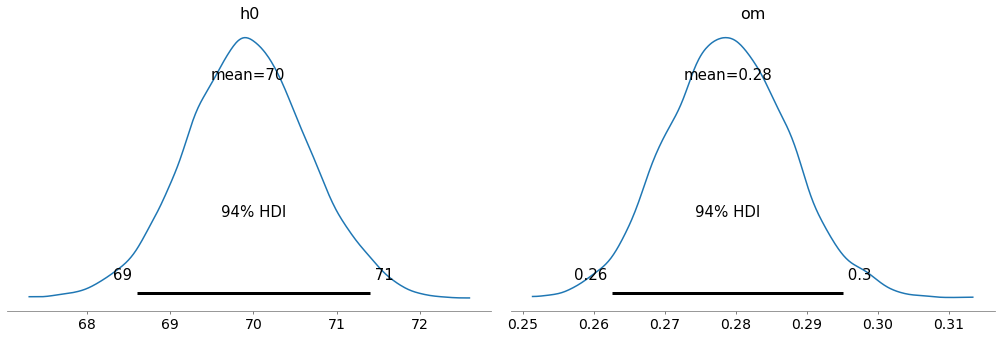

In [28]:
az.plot_posterior(idata)

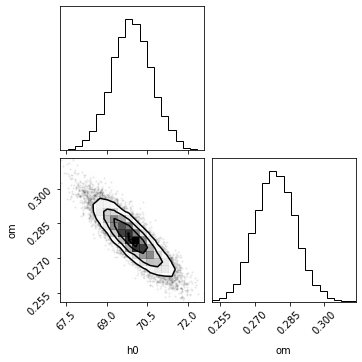

In [29]:
corner.corner(idata)
plt.show()

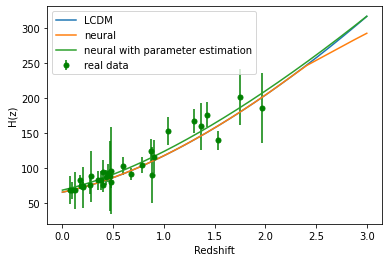

In [30]:
z_data = data.values[:,0]
hz_data = data.values[:,1]
err_data = data.values[:,2]

plt.plot(zredshift, hlcdm, label='LCDM')
plt.xlabel('Redshift')
plt.plot(zredshift, news_h, label='neural')
plt.plot(zredshift, Hlcdm(69,0.32), label='neural with parameter estimation')
plt.ylabel('H(z)')
plt.errorbar(z_data, hz_data, yerr=err_data, label='real data', fmt='g.', markersize=10)
plt.legend()